# Sheet 10 - Time evolution of the Transverse Field Ising Model


The Ising model is spin model composed of a lattice of spin-1/2 particles interacting via nearest-neighbour interaction. In this tutorial we consider the quantum transverse field Ising model, which adds a (uniform) magnetic field in the x direction.
The full Hamiltonian describing this system is:

\begin{align}
\hat{H} &= - J \sum_{i=0}^{N_{spins}-1} Z_{i+1} \otimes Z_i - \Gamma  \sum_{i=0}^{N_{spins}-1} X_i \\
&\equiv - J \sum_{i=0}^{N_{spins}-1} Z_{i+1} Z_i - \Gamma  \sum_{i=0}^{N_{spins}-1} X_i
\end{align}

where each spin has been mapped to one qubit.

The goal of the tutorial is to implement a quantum circuit describing the time evolution of this system using Trotterization of the evolution operator (at leading order), and to compare the results to the exact time evolution. 

##### We will assume periodic boundary conditions, meaning that $Z_{N_{spins}} \equiv Z_{0}$.

In [1]:
from qiskit import *
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info.operators import Operator
pi = np.pi

<h4 style="font-size: 17px">&#128211; 1) Create a function that implements the operator 

\begin{align} 
e^{-i \alpha Z_j Z_i} 
\end{align}

</h4>

In [2]:
###### your code:
def exp_zz(qc, alpha, qubits): 
#qubits: i,j, onto which apply Z

    #compute parity and store it in the second qubit
    qc.cx(qubits[0], qubits[1])
    
    #apply parametrized rotation on the second qubit
    qc.rz(2*alpha, qubits[1])
    
    #uncompute parity
    qc.cx(qubits[0], qubits[1])
       
    return qc
#################

<h4 style="font-size: 17px">&#128211; 2) Use your function defined above to build another function taking as input an initial-state circuit and returning a circuit for the time-evolved state $|\Psi(t)\rangle$ (at leading-order in Trotterization) for a given value of time $t$ </h4>

In [4]:
###### your code:
def ising_time_evo(qc, t, J, Gamma):
    
    for i in range(qc.num_qubits):
        #apply e^(i J ZZ) on nearest neighbours
        qc = exp_zz(qc, -J*t, [i, (i+1)%qc.num_qubits]) #% to enforce pbc
        #apply e^(i Gamma X) on each qubit
        qc.rx(-2*Gamma*t, i)
        
    return qc
#################

<h4 style="font-size: 17px">&#128211; 3) Create now a function that takes as input the state $| \Psi(t) \rangle$ evolved to a given time $t$, measures and returns the magnetization: </h4>

$$
M =  \langle \Psi(t) |  \sum_{i=0}^{N_{spins}-1} Z_i | \Psi(t) \rangle
$$

where 
$$ 
Z_i \equiv I_{N_{spins}-1} \otimes ... \otimes I_{i+1} \otimes Z_i \otimes I_{i-1} ... \otimes I_{0}
$$

In [5]:
###### your code:
def magnetization(qc):
    #takes input state in form of a circuit
    qc.measure_all()
    simulator = Aer.get_backend('qasm_simulator')
    tot_shots=1e4
    trans_circuit = transpile(qc, backend=simulator)
    job = simulator.run(trans_circuit, shots=tot_shots)
    counts = job.result().get_counts(qc)
    exp_value = 0
    for value in counts:
        up_spins = sum(int(x) for x in value) #count the number of 1s in the state
        exp_value += up_spins * counts[value]/tot_shots
    return exp_value
#################

<h4 style="font-size: 17px">&#128211; (4) Consider a system of $ N_{spins} = 6 $ spins,
in an initial state where all spins are aligned in the $z$ direction: $$| \Psi(0)\rangle = |000000\rangle \equiv |\uparrow\uparrow\uparrow\uparrow\uparrow\uparrow\rangle$$ and use your previsously-defined functions to compute and plot the time evolution of the magnetization for $t \in [0,3]$.


Compare and discuss the results for two sets of parameters: 
- a) $J=1$, $\Gamma =0$
- b) $J=1$, $\Gamma =3$

Vary the number of Trotter steps $N_s$ (for example, from $N_s = 1$ to $N_s = 20$).

</h4>

In [6]:
###### your code:
def magnetization_over_time(J, Gamma, Ns):
    
    num_spins = 6
    
    #initial state
    qc = QuantumCircuit(num_spins)
    
    ms = []
    
    #evolve up to time t
    for t in np.arange(0, 3, 0.1):
        evo_circ = qc.copy()
        #apply evolution over Ns Trotter steps
        for _ in range(Ns): 
            evo_circ = ising_time_evo(evo_circ, t/Ns, J, Gamma)
        #compute magnetization of the evolved state
        m = magnetization(evo_circ)
        ms.append(m)
        
    return np.arange(0, 3, 0.1), ms   
    
#################

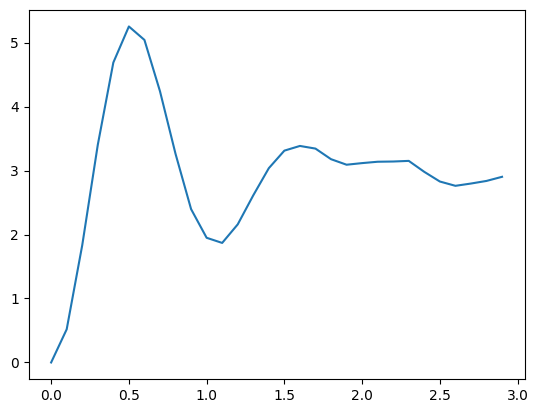

In [7]:
J = 1
Gamma = 3
Ns = 20
times, ms = magnetization_over_time(J, Gamma, Ns)
plt.plot(times, ms, label='Magnetization')

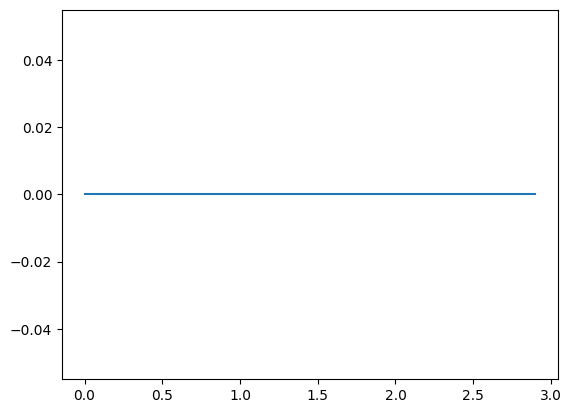

In [8]:
J = 1
Gamma = 0
Ns = 1
times, ms = magnetization_over_time(J, Gamma, Ns)
plt.plot(times, ms, label='Magnetization')

<h4 style="font-size: 20px"> We now want to compare the results above to the exact time-evolution. </h4>
In principle this can be done using the software of your choice (Mathematica, Python etc...).
In Python, this can be done by diagonalizing  and exponentiating the Hamiltonian matrix, which is what we will do below.

<h4 style="font-size: 17px">&#128211; 5) First, create the exact Hamiltonian matrix</h4>
You can use the numpy "kron" fucntion which compute the Kronecker (tensor) product of matrices, as shown below. Note that this function only takes two arguments.


In [9]:
## examples
X_mat = np.array( [ [0,1], [1,0] ] )
I_mat = np.array( [ [1,0], [0,1] ] )
Z_mat = np.array( [ [1,0], [0,-1] ] )
ZZ = np.kron(Z_mat, Z_mat)
IZZ = np.kron(I_mat, ZZ)

##### your code:
def build_H (J, Gamma):
    import functools as ft

    ZZIIII = ft.reduce(np.kron, [Z_mat, Z_mat, I_mat, I_mat, I_mat, I_mat])
    IZZIII = ft.reduce(np.kron, [I_mat, Z_mat, Z_mat, I_mat, I_mat, I_mat])
    IIZZII = ft.reduce(np.kron, [I_mat, I_mat, Z_mat, Z_mat, I_mat, I_mat])
    IIIZZI = ft.reduce(np.kron, [I_mat, I_mat, I_mat, Z_mat, Z_mat, I_mat])
    IIIIZZ = ft.reduce(np.kron, [I_mat, I_mat, I_mat, I_mat, Z_mat, Z_mat])
    ZIIIIZ = ft.reduce(np.kron, [Z_mat, I_mat, I_mat, I_mat, I_mat, Z_mat])

    XIIIII = ft.reduce(np.kron, [X_mat, I_mat, I_mat, I_mat, I_mat, I_mat])
    IXIIII = ft.reduce(np.kron, [I_mat, X_mat, I_mat, I_mat, I_mat, I_mat])
    IIXIII = ft.reduce(np.kron, [I_mat, I_mat, X_mat, I_mat, I_mat, I_mat])
    IIIXII = ft.reduce(np.kron, [I_mat, I_mat, I_mat, X_mat, I_mat, I_mat])
    IIIIXI = ft.reduce(np.kron, [I_mat, I_mat, I_mat, I_mat, X_mat, I_mat])
    IIIIIX = ft.reduce(np.kron, [I_mat, I_mat, I_mat, I_mat, I_mat, X_mat])

    return -J*(ZZIIII + IZZIII + IIZZII + IIIZZI + IIIIZZ + ZIIIIZ) - Gamma*(XIIIII + IXIIII + IIXIII + IIIXII + IIIIXI + IIIIIX)
#################

Below we provide a function that takes as input the Hamiltonian matrix, computes its eigenvalues, exponentiate it to obtain the exact evolution operator and converts it the corresponding quantum circuit. The function returns the exact evolved state $| \Psi(t) \rangle$ for a given value of $t$:

In [10]:
def exact_evol(ini_state, Hami, Nspins, t):
    
    eigenvalue, P = np.linalg.eigh(np.array(Hami))
    e_iHt = np.diag(np.exp(-1.0j*eigenvalue*t))
    e_iHt = np.dot(P, np.dot(e_iHt, P.T))
    
    op = Operator(e_iHt)
    
    circuit_exact = QuantumCircuit(Nspins)
    circuit_exact.unitary(op, range(Nspins))

    evolved_state = ini_state.compose(circuit_exact)

    return evolved_state

<h4 style="font-size: 17px">&#128211; 6) Compute the exact time evolution of the magnetization, and compare to your previous results with leading-order Trotterization for different numbers of Trotter steps.

In [11]:
def magnetization_over_time_exact(J, Gamma):
    
    num_spins = 6
    
    #initial state
    initial_state = QuantumCircuit(num_spins)
    
    ms = []
    H = build_H(J, Gamma)
    
    #evolve up to time t
    for t in np.arange(0, 3, 0.1):
        evolved_state = exact_evol(initial_state, H, num_spins, t)
        #compute magnetization of the evolved state
        m = magnetization(evolved_state)
        ms.append(m)
        
    return np.arange(0, 3, 0.1), ms 

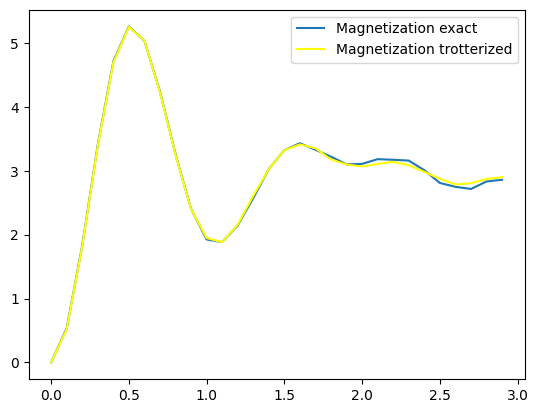

In [16]:
J = 1
Gamma = 3
times, ms = magnetization_over_time_exact(J, Gamma)
Ns = 21
times, ms_trotter = magnetization_over_time(J, Gamma, Ns)
plt.plot(times, ms, label='Magnetization exact')
plt.plot(times, ms_trotter, label='Magnetization trotterized', color='yellow')
plt.legend(loc='upper right')